<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/Draft_CNN_project_Fereshteh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt

def get_data():
  data_set=torch.load('/content/gdrive/My Drive/Colab Notebooks/1k-images.pt')
  return  data_set

Data Loading and Splitting

In [6]:
# Prepare Dataloader
def get_data_loader( classes , batchsize, dataset):

  indices = np.arange(len(dataset))

# Split into train and validation  test
  np.random.seed(20) # Fixed numpy random seed for reproducible shuffling
  np.random.shuffle(indices)
  split = int(len(indices) * 0.6) #split at 60%
  split2=int(len(indices)*0.8)

#  # split into training and validationand test indices
  relevant_train_indices, relevant_val_indices  ,relevant_test_indices = indices[:split], indices[split:split2] , indices[split2:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,num_workers=1, sampler=train_sampler)
                                      
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                              num_workers=1, sampler=val_sampler)
  # # Get the list of indices to sample from
  
  test_sampler = SubsetRandomSampler(relevant_test_indices)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                          num_workers=1, sampler=test_sampler)
  
  return train_loader, val_loader, test_loader

In [7]:
# # Verification Step - obtain one batch of images
def verify(data_loader,classes):

  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()

  images = images.numpy()
  
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(images[idx])
      ax.set_title(classes[labels[idx]])

In [8]:
def save_features(data_loader,loader_name,feature_path, classes):
  n = 0
  for img, label in data_loader:
    img=img.permute(0,3,1,2)
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = feature_path + '/' +loader_name+'/'+ str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  print(loader_name,"features saved")

In [46]:
# Prepare Dataset
dataset= get_data()

In [60]:
# Prepare DataLoader
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']
train_loader, val_loader, test_loader=get_data_loader(classes=classes, batchsize=32, dataset=dataset)

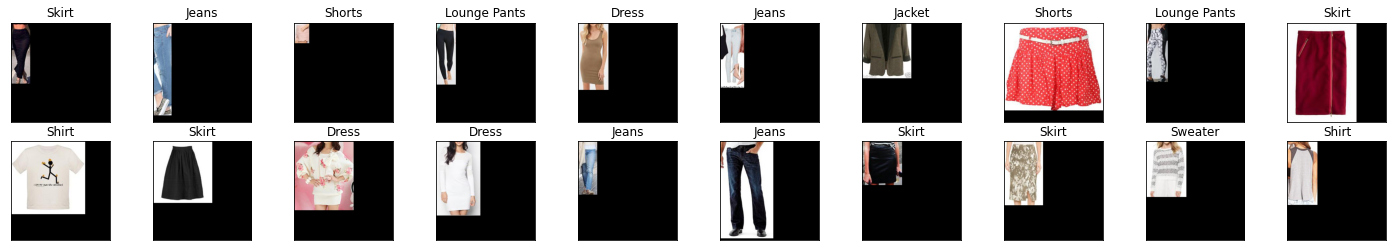

In [61]:
verify(train_loader,classes)


**Only Run the following if you don't have the features of AlexNet**

In [ ]:
import torchvision.models
import os
alexnet = torchvision.models.alexnet(pretrained=True)

# initialize path
feature_path = '/content/gdrive/My Drive/Colab Notebooks/8k-features'

# Prepare Dataloader 
dataset= get_data()
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']
train_loader, val_loader, test_loader=get_data_loader(classes=classes, batchsize=1, dataset=dataset)


save_features(train_loader,"train",feature_path, classes=classes)
save_features(val_loader,"val",feature_path, classes=classes)
save_features(test_loader,"test",feature_path, classes=classes)

In [ ]:
#free up some memory
del dataset

In [4]:
def get_alex_data_loader(batch_size):
  train_dir = '/content/gdrive/My Drive/Colab Notebooks/8k-features/train'
  test_dir = '/content/gdrive/My Drive/Colab Notebooks/8k-features/test'
  val_dir = '/content/gdrive/My Drive/Colab Notebooks/8k-features/val'
  train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.tensor'))
  val_set= torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.tensor'))
  test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.tensor'))
  torch.manual_seed(1) # set the random seed

  num_workers = 1
  train_feature_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  test_feature_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  val_feature_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)


  return train_feature_loader, test_feature_loader,val_feature_loader

In [25]:
#Prepare feature loader
train_feature_loader, test_feature_loader,val_feature_loader=get_alex_data_loader(32)

In [23]:
# Verification Step - obtain one batch of features
dataiter = iter(val_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

KeyboardInterrupt: ignored

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_ALEX(nn.Module):
    def __init__(self):
        super(CNN_ALEX, self).__init__()
        self.name="CNN_ALEX"
        self.conv = nn.Conv2d(256, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(10* 3* 3, 32)
        self.fc2 = nn.Linear(32, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(x.shape[0], 10* 3* 3) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [9]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [10]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [28]:
def train_net(model,target_classes,train_loader,val_loader, batch_size=64, learn_rate=0.001, num_epochs=30):
    ########################################################################
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy,which will apply softmax to the output layer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time=time.time()
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            # Forward pass, backward pass, and optimize
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_loss[epoch] = float(total_train_loss) / (batch_size)
        train_acc[epoch]= get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch]
                   ))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')

    end_time= time.time()

    # Write the train/test loss/err into CSV file 
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time: " , (end_time-start_time))


    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

TO DO: Hyper parameter tuning

Epoch 1: Train acc: 0.539125, Train loss: 10.986758396029472 |Validation acc: 0.523125
Epoch 2: Train acc: 0.585375, Train loss: 9.329383151605725 |Validation acc: 0.5925
Epoch 3: Train acc: 0.564875, Train loss: 8.802154844626784 |Validation acc: 0.55875
Epoch 4: Train acc: 0.561875, Train loss: 8.437940774485469 |Validation acc: 0.566875
Epoch 5: Train acc: 0.605, Train loss: 8.186761047691107 |Validation acc: 0.61125
Epoch 6: Train acc: 0.617625, Train loss: 8.070491448044777 |Validation acc: 0.61
Epoch 7: Train acc: 0.659375, Train loss: 7.8173012267798185 |Validation acc: 0.6625
Epoch 8: Train acc: 0.651375, Train loss: 7.838596494868398 |Validation acc: 0.6475
Epoch 9: Train acc: 0.65, Train loss: 7.6876410292461514 |Validation acc: 0.649375
Epoch 10: Train acc: 0.639375, Train loss: 7.498162694275379 |Validation acc: 0.63875
Epoch 11: Train acc: 0.679375, Train loss: 7.398272321559489 |Validation acc: 0.68125
Epoch 12: Train acc: 0.664625, Train loss: 7.189900113269687 |Validati

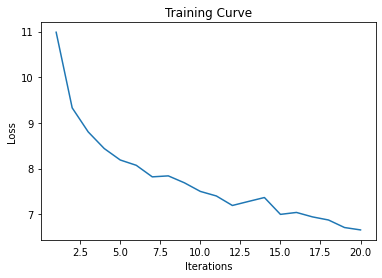

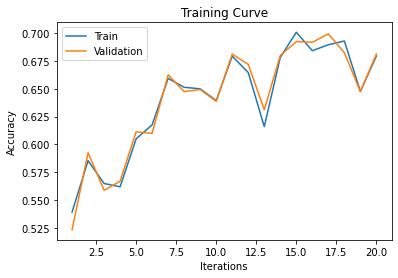

In [29]:
use_cuda = True
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']

model=CNN_ALEX()
#Modify
if use_cuda and torch.cuda.is_available():
    model.cuda()
train_net(model, classes,train_feature_loader, val_feature_loader, batch_size=32, num_epochs=20, learn_rate = 0.01)

In [35]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/CNN_Alex_8k")

In [36]:
model.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/CNN_Alex_8k"))

<All keys matched successfully>

In [37]:
get_accuracy(model,train_feature_loader)

0.65425

In [38]:
get_accuracy(model,test_feature_loader)

0.6525

In [42]:
def get_confusion_matrix(model, data_loader):
    correct = 0
    total = 0
    nb_classes = 8

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():

      for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        
        for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    # Visualize it as a heatmap
    import seaborn
    seaborn.heatmap(confusion_matrix)
    plt.show()

tensor([[154.,   3.,   0.,   1.,  18.,   0.,   8.,  12.],
        [ 14., 112.,   9.,   2.,  21.,   2.,  10.,  27.],
        [  0.,   1., 146.,  48.,   0.,   5.,  12.,   1.],
        [  1.,   0.,  38., 137.,   0.,   4.,  21.,   0.],
        [ 11.,   7.,   0.,   0., 156.,   5.,   6.,  17.],
        [  2.,   2.,   3.,  13.,   2., 158.,  37.,   3.],
        [  7.,   0.,   4.,   7.,   0.,  41., 123.,   2.],
        [ 11.,  20.,   1.,   1.,  94.,   0.,   2.,  58.]])
tensor([0.7857, 0.5685, 0.6854, 0.6816, 0.7723, 0.7182, 0.6685, 0.3102])


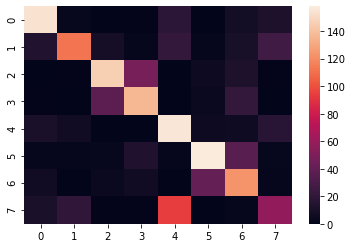

In [43]:
get_confusion_matrix(model,test_feature_loader)